In [ ]:
!pip install --upgrade pip setuptools wheel
!pip install tensorflow==2.15.0

In [ ]:
import pennylane as qml
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split

import math
import random
import matplotlib.pyplot as plt

random.seed(10)

In [ ]:
# Suppress TensorFlow casting warnings for complex128 to float64
# This is safe because expectation values are always real

import os
import warnings
import logging


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress INFO and WARNING messages

# Suppress TensorFlow Python warnings
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore', message='.*casting.*complex128.*float64.*')
warnings.filterwarnings('ignore', message='.*You are casting.*')


In the context of quantum variational algorithm, we focus on the gate $R_G$ generated by fixed operators $G \in \mathcal{G}$ where $\mathcal{G}$ are the fixed gatesets,

\begin{equation*} 
R_G(\theta) = exp(-i \theta G)
\end{equation*}\\

\
The symmetry group $\mathcal{S}$ is embodied by the unitary representation $U_s$ for $s \in \mathcal{S}$. And a gate is equivarant with respect to the symmetry if 

\begin{equation*} 
[R_G(\theta), U_s] = 0,\ \ \  \forall \theta \in \mathbb{R},\ \  \forall s \in \mathcal{S}
\end{equation*}\\

\
Futhermore, for a given gate $R_G$,
\begin{equation*} 
[R_G(\theta), U_s] = 0\ \ \  \Longleftrightarrow \ \ \ [G, U_s] = 0
\end{equation*}\\

We call a data encoding unitary $U(x)$ equivariant with respect to the data symmetry $V_s$ if the unitary lives in the adjont representation of $U_s$, i.e.

\begin{equation*} 
U(V_s [x]) = U_s U(x) U^\dagger _s
\end{equation*}\\


Twirling formula gives us the operators equivariant with respect to the summetry group ($S$).

\begin{equation*} 
\begin{split}
\mathcal{T}_U[x] &= \frac{1}{|s|} \sum_{s\in S}U_s X U^{\dagger}_s \\
&= \int d\mu (s) U_s X U^{\dagger}_s
\end{split}
\end{equation*}\\

$\Rightarrow [\mathcal{T}_U[x], U_s] = 0,\ \ \  \forall x$ and $\forall s \in S$.




Prepare the board

In [2]:
# Create an empty board
def create_board():
    return np.array([[0,0,0],[0,0,0],[0,0,0]])

# Find empty places on the board
def empty_places(board):
    empty_places = []
    for i in range(3):
        for j in range(3):
            if board[i,j] == 0:
                empty_places.append((i,j))
    return empty_places

# Player selects a random place on the board to play
def random_play(board,player):
    possible_places = empty_places(board)
    player_selection = random.choice(possible_places)
    board[player_selection] = player
    return board

1) Set up the 3 winning conditions 

2) Check if the winning conditions are met

In [3]:
# 1) Check 3 in a row
def row_win(board,player):
    for x in range(3):
        win = True
        for y in range(3):
            if board[x,y] != player:
                win = False

        if win:
            break

    return win


# 2) Check 3 in a column
def column_win(board,player):
    for x in range(3):
        win = True
        for y in range(3):
            if board[y,x] != player:
                win = False

        if win:
            break

    return win


# 3) Check 3 in a diagonal
def diagonal_win(board,player):
    win1 = True
    win2 = True
    for x,y in zip(range(3),range(3)):
        if board[x,y] != player:
            win1 = False

    for x,y in zip(range(3),reversed(range(3))):
        if board[x,y] != player:
            win2 = False

        if win1 or win2:
            break

    return win1 or win2


# Check if one of the winning conditions is met
def evaluate_game(board):
    winner = None
    for player in [1,-1]:
        if row_win(board,player) or column_win(board,player) or diagonal_win(board,player):
            winner = player 

    if len(empty_places(board)) == 0 and winner == None:
        winner = 0

    return winner 

Start the game and record the results

In [4]:
# Combine all functions to play the game
def play_game():
    board = create_board()
    winner = None
    counter = 1

    while winner == None:
        for player in [1,-1]:
            board = random_play(board,player)
            counter += 1
            winner = evaluate_game(board)

            if winner != None:
                break

    return [np.ndarray.flatten(board), winner]



In [5]:
# Create a dictionary to store the data of each training
def create_dataset(size_of_each_winner:int):
    game_result = {-1:[], 0:[], 1:[]}
    
    
    while np.max([len(winner_size) for _,winner_size in game_result.items()]) < size_of_each_winner:
        board, winner = play_game()
        game_result[winner].append(board)

    # Convert dictionary to list
    result = []
    for winner,boards in game_result.items():
        result += [(board,winner) for board in boards]

    return result


<img src="graphics/indexing.png" width="300" />

This is the indexing scheme of our tic-tac-toe game. We are assigning 1 qubit for each index, so we will be working with 9 qubits in total. 

This board resembles a $D_4$ group, if we denote the generators of the $D_4$ group by $a,b$ where $a$ generates $\frac{\pi}{2}$ anti-clockwise rotation and $b$ generates a filp or reflection around the vertical axis through the center. Then we can denote the 8 elements of the $D_4$ group as $\{\mathbb{1},a,a^2,a^3,ab,a^2b,a^3b\}$.

<img src="graphics/D4_symmetry.png" width="300" />

Above figure shows the actions of the 8 generators of $D_4$ group on our game. 


Next, we would like to express these 8 generators in the context of quantum circuit and quantum gates. First, we utilize the fact that the $D_4$ or dihedral groups in are general a subgroup of permutation group $S_n$. Follwoing our indexing scheme, the 8 elements of the $D_4$ group are expressed as the following permutations,

\begin{equation*}
\begin{split}
\mathbf{1}\ \ \ &\to \mathbf{1}\\
a\ \ \ &\to (0286)(1573)\\
a^2\ \ \ &\to (08)(26)(17)(35)\\
a^3\ \ \ &\to (0682)(1357)\\
b\ \ \ &\to (26)\\
ab\ \ \ &\to (02)(35)(68)\\
a^2b\ \ \ &\to (08)\\
a^3b\ \ \ &\to (06)(17)(28).
\end{split}
\end{equation*}

The permutations of $D_4$ group show us 3 observations on the vertices (if we treat each position on our board as one vertex):
1) The center of the board (4) is not involved in any actions.

2) The corners (0,2,6,8) permute together as a goup

3) The edges (1,3,5,7) permute together as a goup

These observations motivate us to group the 9 postions of our board into 3 equivalence classes of invariant observable $(O)$. 

\begin{equation*}
\begin{split}
O_{middle} &= Z_4\\
O_{corners} &= \frac{1}{4}[Z_0+Z_2+Z_6+Z_8] \\
O_{edges} &= \frac{1}{4}[Z_1+Z_3+Z_5+Z_7], 
\end{split}
\end{equation*}\\
where $Z_i,\ i \in (1,9)$ are the expectation value of the 9 positions of our board. Therefore, the qubits living in the same equivalence class should undergo the same symmetry operation. In other word, a single-qubit gate has to act on the qubits in the same equivalence class equally. 

We choose the single-qubit gate acting on each vertex to be 
\begin{equation*}
R_Y(\theta_2)R_X(\theta_1).
\end{equation*}\\
Then, generalizing into our board, if $D_4$ symmetry is not considered, we would need 18 parameters since two parameters are needed for each of the 9 vertices.
On the other hand, if $D_4$ symmetry is considered, only 6 parameters are needed since we need two parameters for each of the 3 equivalence classes.

<img src="graphics/single_qubit_gate.png" width="300" />

The image summerize the 3 equivalence classes with the yellow box representing the middle class, the green boxes representing the corners class and the red boxes representing the edges class.


Next, we are going to investigate the $D_4$ group on the edge level (the edge connecting two boxes). To do this, we study the effect of $D_4$ permutation again, focuing on the actions involving $b$ this time,

\begin{equation*}
\begin{split}
b\ \ \ &\to (26)\\
ab\ \ \ &\to (02)(35)(68)\\
a^2b\ \ \ &\to (08)\\
a^3b\ \ \ &\to (06)(17)(28).
\end{split}
\end{equation*}\\

The above permutaion only presents the final result of the vertices after the action, but if we consider the edges as well, the permutation can be rewritten as the following,

\begin{equation*}
\begin{split}
b\ \ \ \ \to \ \ \ \ \ \ \ \ \ \ \ \ \ \ (26) &\to (24)(46)\\
ab\ \ \ \to (02)(35)(68) &\to (01)(12)\ (34)(45)\ (67)(78) \\
a^2b\ \ \ \to \ \ \ \ \ \ \ \ \ \ \ \ \ \  (08) &\to (04)(48)\\
a^3b\ \ \ \to (06)(17)(28) &\to (03)(36)\ (14)(47)\ (25)(58).
\end{split}
\end{equation*}\\

Then, we observe all these edges into the 3 equivalence classes again, namely

1) Edges between middle and corners: $(42)(46)(40)(48)$

2) Edges between edges and middle : $(14)(74)(34)(54)$

3) Edges between corners and edges : $(01)(21)(67)(87)(03)(63)(25)(85)$


The following image visulize the 3 equvalence classes with the yellow edges represening the $1.$ class, the red edges represening the $2.$ class and the green edges represening the $3.$ class. 

<img src="graphics/two_qubit_gates.png" width="300" />

We choose the entangling gate acting on these edges to be 
\begin{equation*}
CR_Y(\theta).
\end{equation*}\\

Therefore, without considering symmetry, we need 16 parameters to represent the rotations of the edges. While with $D_4$ symmetry, we need 3 parameters, one for each equivalence classes. 

All in all, $D_4$ symmetry reduced the number of parameter from $34 (18+16)$ to $9 (6+3)$.

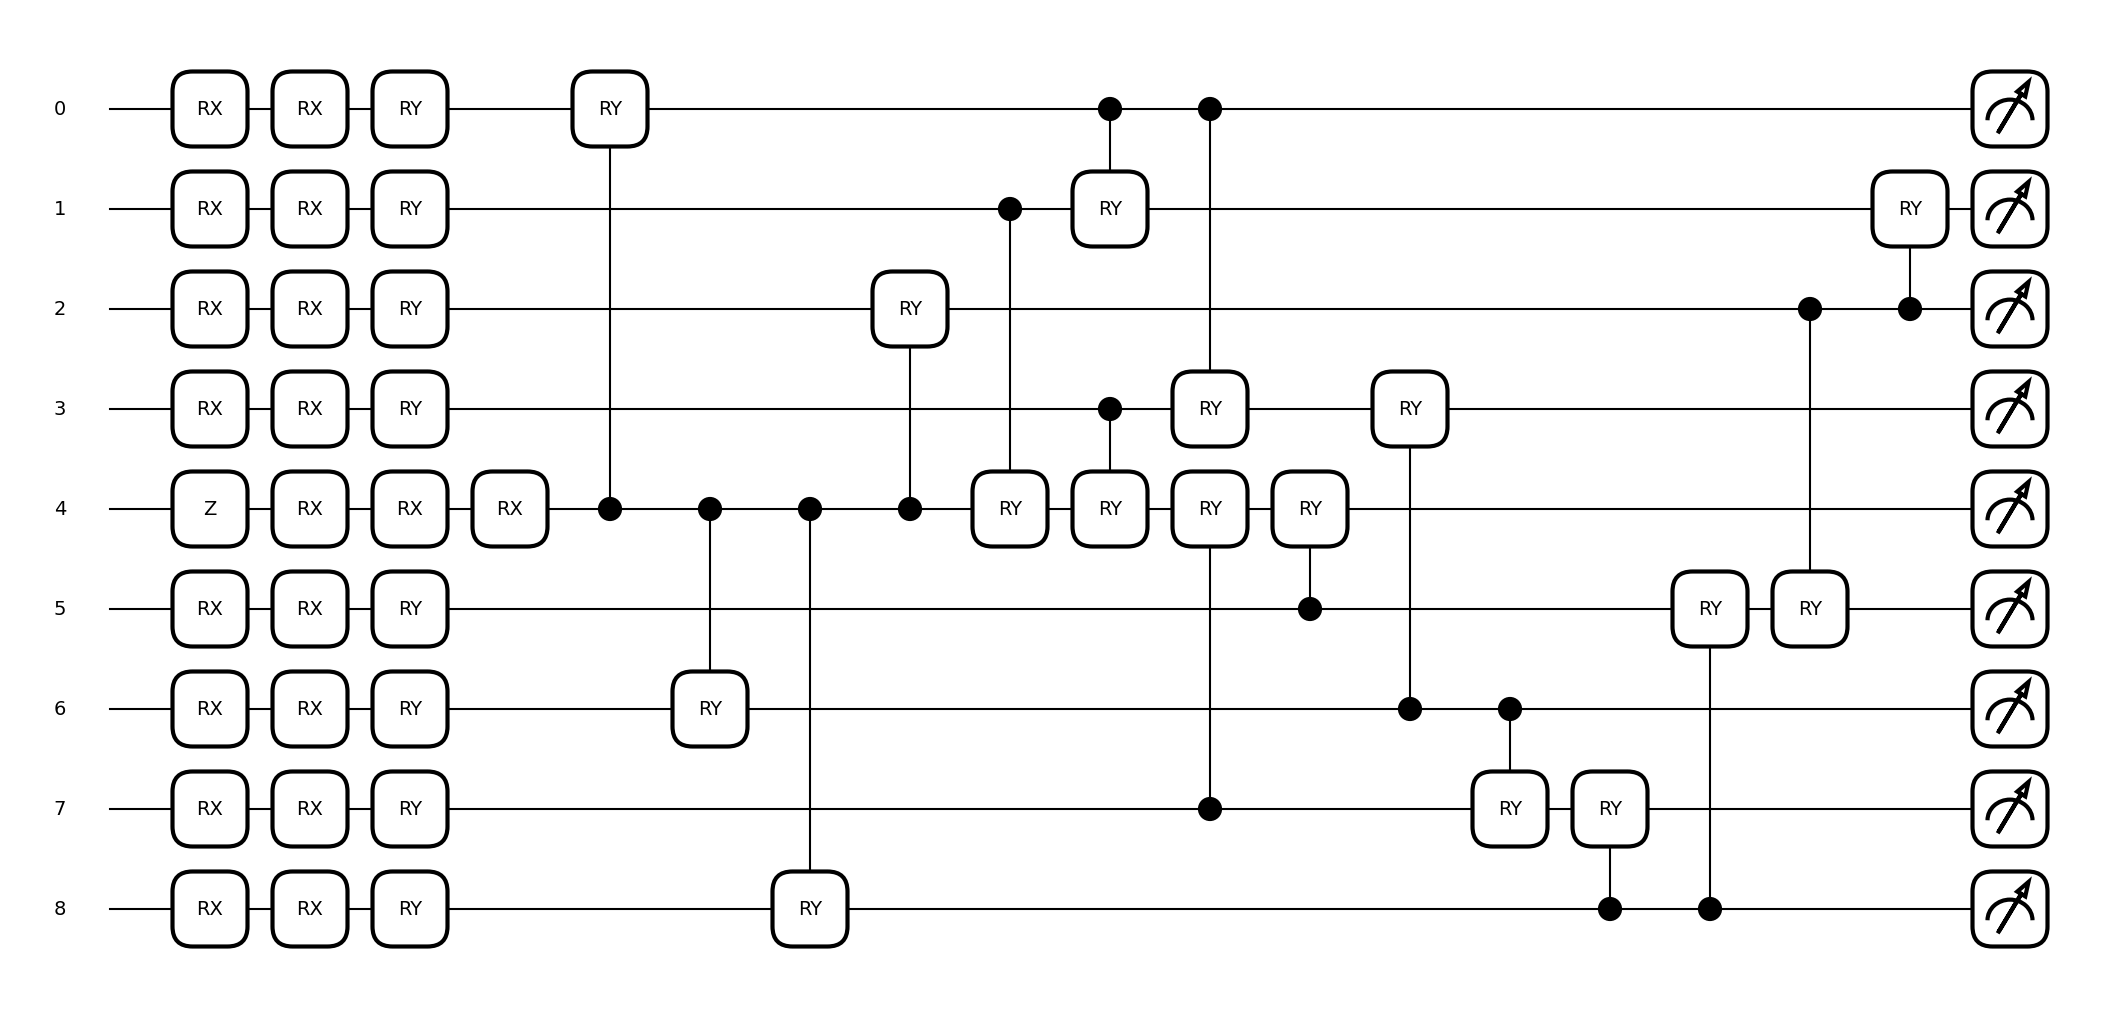

In [6]:
dev = qml.device('default.qubit', wires = 9)


@qml.qnode(dev, interface='tf')
def circuit_with_symm(x,p):

    center = qml.PauliZ(4)
    corners = (qml.PauliZ(0) + qml.PauliZ(6) + qml.PauliZ(8)  + qml.PauliZ(2)) * (1/4)
    edges =  (qml.PauliZ(1) + qml.PauliZ(3) + qml.PauliZ(7)  + qml.PauliZ(5)) * (1/4)

    corner_qubits = [0,6,8,2]
    edge_qubits = [1,3,7,5]

    # Initialize the qubits (will be discussed later)
    for i in range(9):
        qml.RX(x[i], wires=i)

################### One-qubit gates  #############################

    # Centre single qubit rotation
    qml.RX(p[0], wires= 4)
    qml.RX(p[1], wires= 4)

    # Corner single qubit rotation
    for i in corner_qubits:
        qml.RX(p[2], wires = i)

    for i in corner_qubits:
        qml.RY(p[3], wires = i)

    # Edge single qubit rotation
    for i in edge_qubits:
        qml.RX(p[4], wires = i)

    for i in edge_qubits:
        qml.RY(p[5], wires = i)

####################### Two-qubits gates #######################

    # Edges between middle and corners rotation
    for i in corner_qubits:
        qml.CRY(p[6], wires = [4,i])


    # Edges between edges and middle rotation
    for i in edge_qubits:
        qml.CRY(p[7], wires = [i,4])


    # Edges between corners and edges rotation
    for index, corner in enumerate(corner_qubits):
        if index != 3:
            qml.CRY(p[8], [corner,edge_qubits[index]])
            qml.CRY(p[8],[corner,edge_qubits[index+1]])

        else:
            qml.CRY(p[8],[corner,edge_qubits[-1]])
            qml.CRY(p[8],[corner,edge_qubits[0]])


    return [qml.expval(qml.PauliZ(i)) for i in range(9)]

fig, ax = qml.draw_mpl(circuit_with_symm)([0]*9,[i for i in range(18)])

Circuit without considering symmetry, 34 parameters are needed.

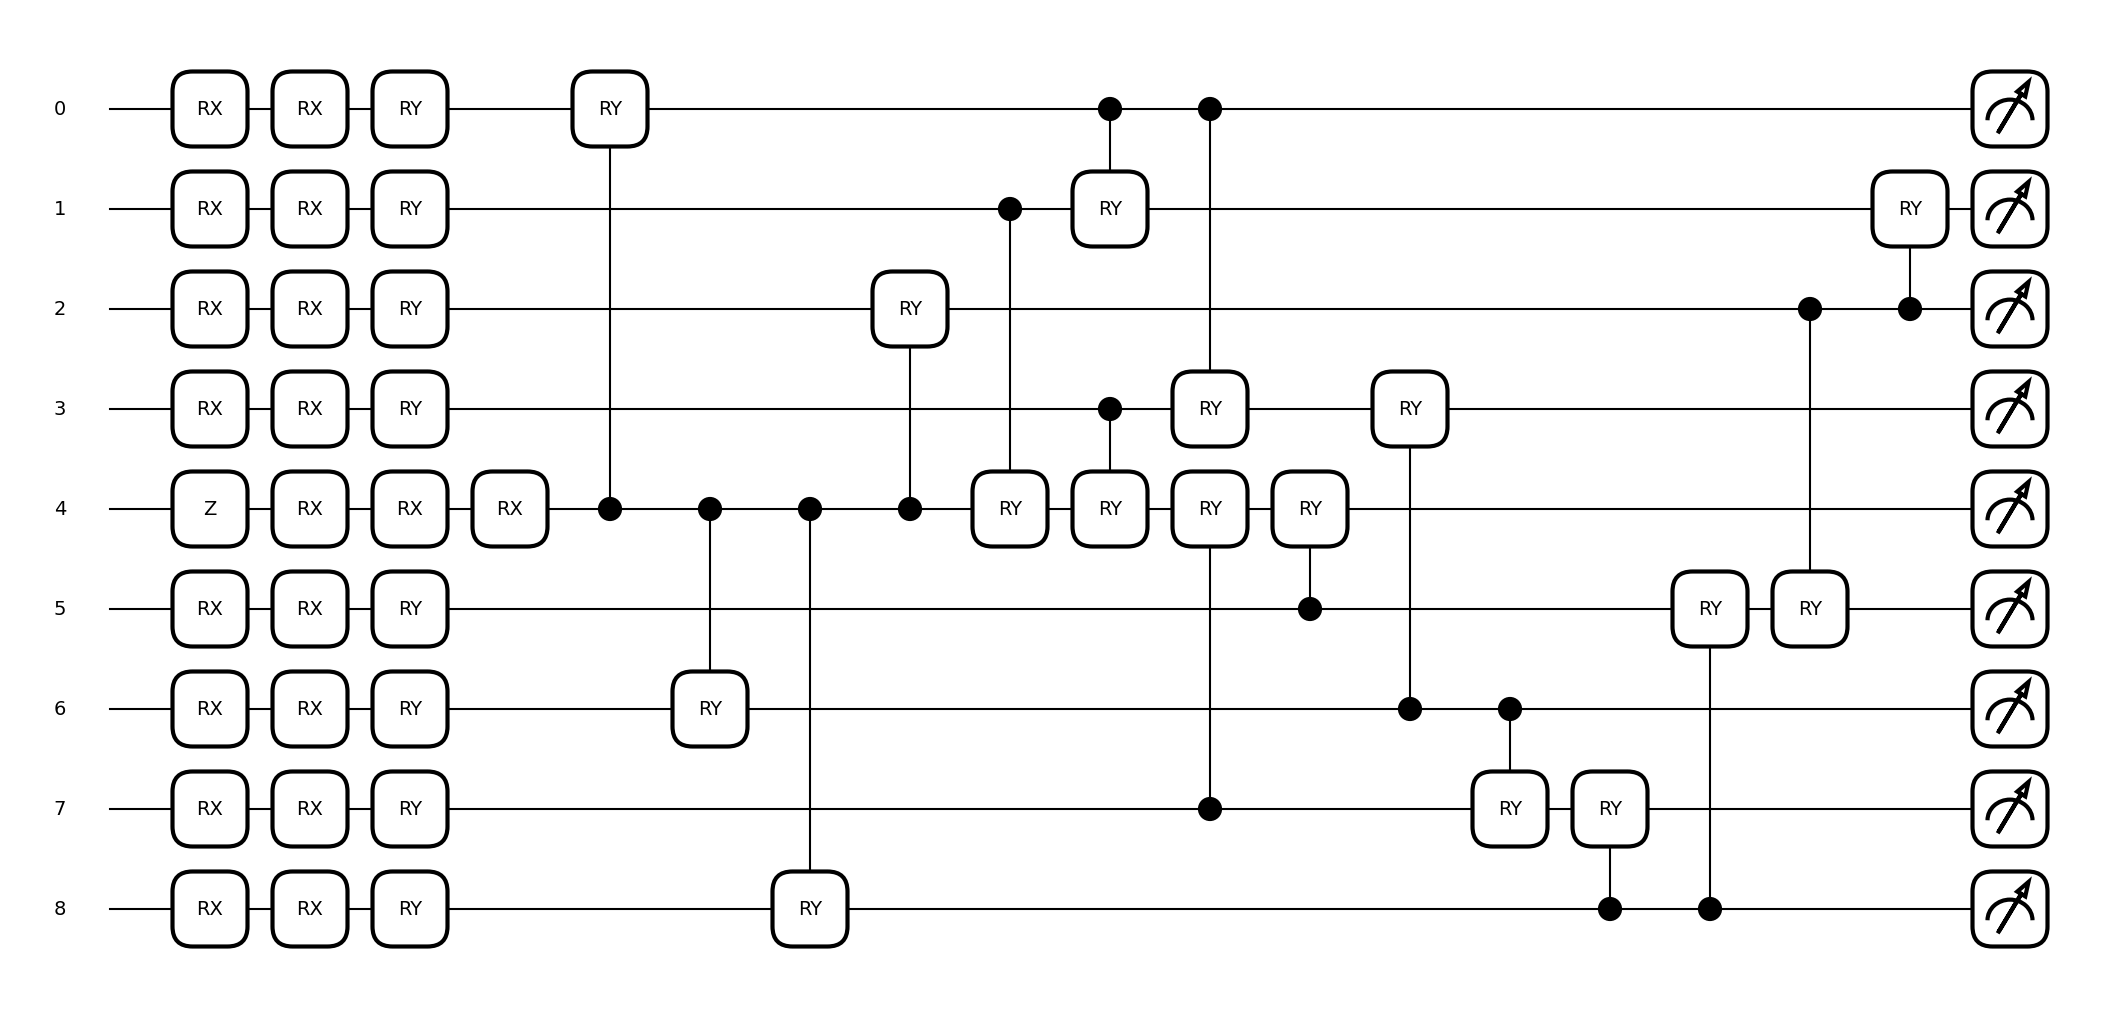

In [7]:
dev = qml.device('default.qubit', wires = 9)

corner_qubits = [0,6,8,2]
edge_qubits = [1,3,7,5]
l = len(corner_qubits)

@qml.qnode(dev, interface='tf')
def circuit_without_symm(x,p):
    # Initialize the qubits (will be discussed later)
    for i in range(9):
        qml.RX(x[i], wires=i)

################### One-qubit gates  #############################

    # Centre single qubit rotation
    qml.RX(p[0], wires= 4)
    qml.RX(p[1], wires= 4)

    # Corner single qubit rotation
    for i,j in zip(corner_qubits, range(2,2+l)):
        qml.RX(p[j], wires = i)

    for i,j in zip(corner_qubits, range(2+l,2+2*l)):
        qml.RY(p[j], wires = i)

    # Edge single qubit rotation
    for i,j in zip(edge_qubits, range(2+2*l,2+3*l)):
        qml.RX(p[j], wires = i)

    for i,j in zip(edge_qubits, range(2+3*l,2+4*l)):
        qml.RY(p[j], wires = i)

####################### Two-qubits gates #######################

    # Edges between middle and corners rotation
    for i,j in zip(corner_qubits, range(2+4*l,2+5*l)):
        qml.CRY(p[j], wires = [4,i])


    # Edges between edges and middle rotation
    for i,j in zip(edge_qubits, range(2+5*l,2+6*l)):
        qml.CRY(p[j], wires = [i,4])


    # Edges between corners and edges rotation
    for index, corner in enumerate(corner_qubits):
        if index != 3:
            qml.CRY(p[2+6*l+2*index], [corner,edge_qubits[index]])
            qml.CRY(p[2+6*l+2*index+1],[corner,edge_qubits[index+1]])

        else:
            qml.CRY(p[32],[corner,edge_qubits[-1]])
            qml.CRY(p[33],[corner,edge_qubits[0]])


    return [qml.expval(qml.PauliZ(i)) for i in range(9)]

fig, ax = qml.draw_mpl(circuit_with_symm)([0]*9,[0]*34)

We have to encode our tic-tac-toe game. Our indexing scheme has alreday assigned 9 qubits to each of the 9 positions on the board. Then, we map the 9 boxes of our board to $(+1,-1, 0)$ which represent a nought, a cross and an emptx box respectively. This can be done by introducing a map $\mathbb{g_i},\ \ i \in {0,8}$. The image below shows an example of the map $g$. This map $g$ is implemented by the empty_places() and random_play() functions.

<img src="graphics/game_encoding.png" width="300" />

Since we instantiate with all $\ket{0}$, the $D_4$ symmetry conditions are automatically satisfied. Therefore, we initiate the circuit with $R_x(x_i)$ where $x_i = \frac{2 \pi}{3} g_i$.

The result of the game is one-hot encoded in vector $\mathbb{y} = (y_o,y_-,y_x)$, where $y_o$ indicates nought won the game while $y_x$ represents cross has won and $y_-$ represnets a 'draw'. A $+1$ will be assigned to the correct label and $-1$ to the other two entries. For example, $(+1,-1,-1)$ represnts a game won by nought.


In [8]:
def encode_game(game):
    board, result = game
    x = board * (2 * math.pi) / 3

    if result == 1:
        y = [-1.,-1.,1.]
    
    elif result == -1:
        y = [1.,-1.,-1.]

    else:
        y = [-1.,1.,-1.]

    return x, y

In [9]:
params = 0.01 * np.random.randn(9)
params_wtihout_symm = tf.Variable(0.01 * np.random.randn(34))


# Prepare training and validation datasets
training_size = 32
training_dataset = create_dataset(training_size)


len(training_dataset)


59

In [10]:
encoded_training_dataset = list(zip(*[encode_game(game) for game in training_dataset]))

x_dataset = np.stack(encoded_training_dataset[0])
y_dataset = np.stack(encoded_training_dataset[1])

x_train, x_test, y_train, y_test = train_test_split(
    x_dataset, y_dataset, test_size=0.3, random_state=42)


### Method 1
We follow the paper [1], where it suggests the following loss function,
\begin{equation*}
L(\mathcal{D}) = \frac{1}{|\mathcal{D}|} \sum_{(g,y)\in \mathcal{D}} ||\hat{y}(g) - y||^2_2.
\end{equation*}

[1] 'Exploiting symmetry in variational quantum machine learning', 2022, arXiv:2205.06217v1

In [ ]:
def optimize_circuit(x_data,y_data,params):

    weights = tf.Variable(params)
    opt = tf.keras.optimizers.RMSprop(learning_rate=1e-1)
    steps = 30

    losses = []
    losses_mean = []
    acc = []
    acc_mean = []
    for _ in range(steps):
        with tf.GradientTape() as tape:
            for i in range(len(x_data)):
                # Suppress warnings during circuit execution
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    result = circuit_with_symm(x_data[i],weights)
                # Convert complex values to real to avoid casting warnings
                # Since expectation values are always real, we can safely take the real part
                result = [tf.cast(tf.math.real(r), dtype=tf.float64) for r in result]
                
                center = result[4]
                corners = (result[0] + result[6] + result[8] + result[2]) * (1/4)
                edges =  (result[1] + result[3] + result[7] + result[5]) * (1/4)

                y_hat = [corners,center,edges]
         
                loss = tf.keras.losses.MSE(y_data[i],y_hat)
                losses.append(loss)

                

        losses_mean.append(tf.math.reduce_mean(losses))
       
        grad = tape.gradient(loss, [weights])

        opt.apply_gradients(zip(grad, [weights]))

    print(weights)
    return losses_mean

In [12]:
print(params)
train_losses = optimize_circuit(x_train, y_train,params)

[ 0.00016469  0.00612979 -0.01279562  0.00329894  0.00393633 -0.00291238
 -0.00178598  0.00368506  0.00324573]
<tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
array([-0.48196819, -0.47600309,  1.37330633,  0.11268916,  2.08865518,
       -0.25063564, -0.07029828, -0.00765992,  0.18355987])>


In [13]:
print(params)
test_losses = optimize_circuit(x_test, y_test,params)

[ 0.00016469  0.00612979 -0.01279562  0.00329894  0.00393633 -0.00291238
 -0.00178598  0.00368506  0.00324573]
<tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
array([ 4.77113189e-01,  4.83078285e-01,  2.08836470e+00, -3.96066225e-02,
        1.70881334e-02, -4.13292740e-02,  1.42696258e-01,  1.74608838e-03,
       -3.32683837e-02])>


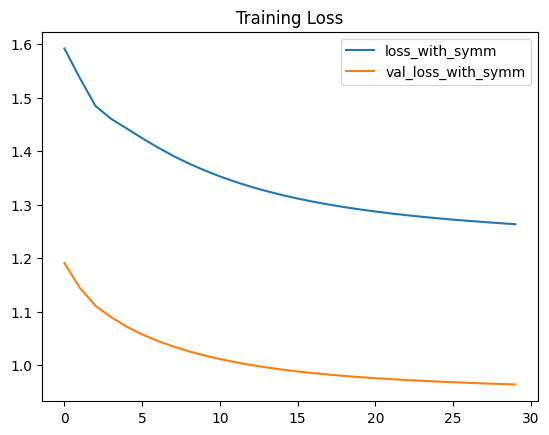

In [14]:
train_losses = train_losses
test_loss = test_losses
epochs = range(len(train_losses))

plt.plot(epochs,train_losses)
plt.plot(epochs,test_losses)

plt.title('Training Loss')

plt.legend(["loss_with_symm", "val_loss_with_symm"])



### Method 2
Train the a simple model by feeding in symmetrized input data.

In [15]:
symmetrized_x_dataset = np.array([circuit_with_symm(x, params) for x in x_dataset])
unsymmetrized_x_dataset = np.array([circuit_without_symm(x, params_wtihout_symm) for x in x_dataset])

In [16]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-2)
loss = tf.keras.losses.MeanSquaredError()

model_with_symm = tf.keras.Sequential([
    
    tf.keras.layers.Dense(8, 'relu'),
    tf.keras.layers.Dense(3,'linear')

])

model_with_symm.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

history_symm = model_with_symm.fit(x=symmetrized_x_dataset,
                         y=y_dataset,
                         batch_size=4,
                         epochs=200,
                         validation_split=0.2,
                         shuffle=True)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5153 - loss: 1.3907 - val_accuracy: 0.2500 - val_loss: 1.1368
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7144 - loss: 0.6606 - val_accuracy: 0.1667 - val_loss: 1.1333
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5600 - loss: 0.6678 - val_accuracy: 0.0833 - val_loss: 1.3525
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6580 - loss: 0.5140 - val_accuracy: 0.4167 - val_loss: 1.1558
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7239 - loss: 0.5031 - val_accuracy: 0.4167 - val_loss: 1.0949
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8282 - loss: 0.4195 - val_accuracy: 0.4167 - val_loss: 1.0823
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7931 - loss: 0.4802 - val_accuracy: 0.4167 - val_loss: 1.1350
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7652 - loss: 0.4313 - val_accuracy: 0.4167 - 

Text(0.5, 1.0, 'Training and Validation Accuracy')

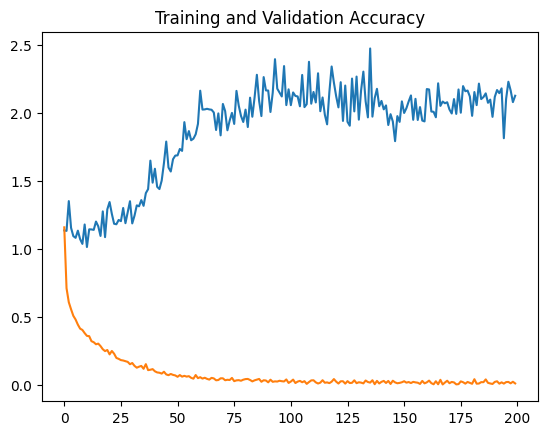

In [17]:
acc = history_symm.history['accuracy']
val_acc = history_symm.history['val_accuracy']

loss = history_symm.history['loss']
val_loss = history_symm.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs,val_loss)
#plt.plot(epochs,val_acc)

plt.plot(epochs,loss)
#plt.plot(epochs,acc)

plt.title('Training and Validation Accuracy')


In [18]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-2)
loss = tf.keras.losses.MeanSquaredError()

model_without_symm = tf.keras.Sequential([
    
  
    
    tf.keras.layers.Dense(34, 'relu'),
    tf.keras.layers.Dense(3,'linear')

])

model_without_symm.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

history_without_symm = model_without_symm.fit(x=unsymmetrized_x_dataset,
                         y=y_dataset,
                         batch_size=4,
                         epochs=200,
                         validation_split=0.2,
                         shuffle=True)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6347 - loss: 0.7490 - val_accuracy: 0.0833 - val_loss: 1.4214
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7471 - loss: 0.4015 - val_accuracy: 0.1667 - val_loss: 1.1531
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8880 - loss: 0.4191 - val_accuracy: 0.0000e+00 - val_loss: 1.8551
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7998 - loss: 0.3417 - val_accuracy: 0.1667 - val_loss: 1.5660
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8707 - loss: 0.3144 - val_accuracy: 0.1667 - val_loss: 1.6869
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9035 - loss: 0.2824 - val_accuracy: 0.1667 - val_loss: 1.8920
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8792 - loss: 0.2528 - val_accuracy: 0.3333 - val_loss: 1.7849
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9233 - loss: 0.2454 - val_accuracy: 0.416

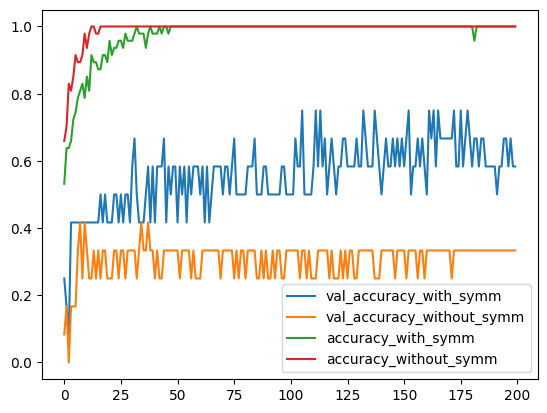

In [19]:
val_accuracy_with_symm = history_symm.history['val_accuracy']
val_accuracy_without_symm = history_without_symm.history['val_accuracy']

accuracy_with_symm = history_symm.history['accuracy']
accuracy_without_symm = history_without_symm.history['accuracy']

loss_with_symm = history_symm.history['val_loss']
loss_without_symm = history_without_symm.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,val_accuracy_with_symm)
plt.plot(epochs,val_accuracy_without_symm)

plt.plot(epochs,accuracy_with_symm)
plt.plot(epochs,accuracy_without_symm)

plt.legend(["val_accuracy_with_symm", "val_accuracy_without_symm",
             "accuracy_with_symm", "accuracy_without_symm"])

#plt.title('Mean Sqaured Loss of symmetrized and unsymmetrized data')

In [20]:
x_without_circuit = tf.stack([data[0] for data in training_dataset])


In [21]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-2)
loss = tf.keras.losses.MeanSquaredError()

model_without_circuit = tf.keras.Sequential([
    
  
    
    tf.keras.layers.Dense(3,'linear')

])

model_without_circuit.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

history_without_circuit = model_without_circuit.fit(x=x_without_circuit,
                         y=y_dataset,
                         batch_size=4,
                         epochs=200,
                         validation_split=0.2,
                         shuffle=True)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0664 - loss: 2.4074 - val_accuracy: 0.2500 - val_loss: 1.8088
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3109 - loss: 1.4939 - val_accuracy: 0.2500 - val_loss: 1.5617
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3995 - loss: 1.2983 - val_accuracy: 0.2500 - val_loss: 1.3495
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4762 - loss: 1.0232 - val_accuracy: 0.4167 - val_loss: 1.1572
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7216 - loss: 0.6809 - val_accuracy: 0.6667 - val_loss: 0.9637
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8279 - loss: 0.5786 - val_accuracy: 0.6667 - val_loss: 0.7988
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9584 - loss: 0.3970 - val_accuracy: 0.6667 - val_loss: 0.6520
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9387 - loss: 0.3165 - val_accuracy: 0.7500 - 

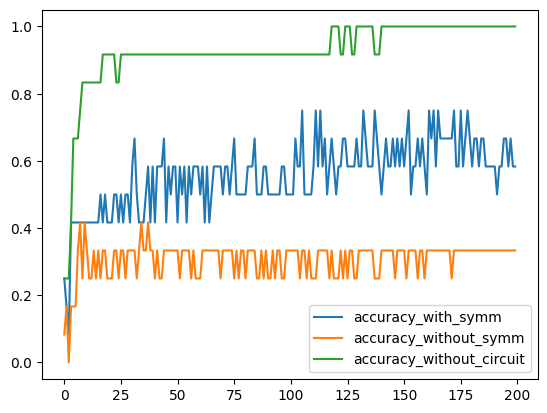

In [22]:
accuracy_with_symm = history_symm.history['val_accuracy']
accuracy_without_symm = history_without_symm.history['val_accuracy']
accuracy_without_circuit = history_without_circuit.history['val_accuracy']

loss_with_symm = history_symm.history['val_loss']
loss_without_symm = history_without_symm.history['val_loss']
loss_without_symm = history_without_circuit.history['val_loss']

epochs = range(len(acc))

#plt.plot(epochs,loss_with_symm)
#plt.plot(epochs,loss_without_symm)

plt.plot(epochs,accuracy_with_symm)
plt.plot(epochs,accuracy_without_symm)
plt.plot(epochs,accuracy_without_circuit)

plt.legend(["accuracy_with_symm", "accuracy_without_symm", 'accuracy_without_circuit'])

#plt.title('Accuracy of symmetrized and unsymmetrized data')